# Part-2 **Text Classification using BERT on AG_News Classification dataset **

The **AG_News_Classification dataset** is a well-used and highly-regarded benchmark dataset consisting of 120,000 news articles from four categories: World, Sports, Business, and Science/Technology. Each article is represented as a bag-of-words with word frequency counts, allowing for efficient processing of text data. The dataset is so famous and has been used to train and evaluate various machine learning models and algorithms, includiang deep learning models such as CNNs and RNNs. Because of its balanced and diverse nature, as well as its large size, I have chosen this dataset to test the performance of BERT on text classification tasks.

In [24]:
!pip install transformers
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
# Set device to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [26]:
# Load the train dataset
df = pd.read_csv('train.csv', header=None, names=['category', 'title', 'description'], on_bad_lines='skip')

# Load the test dataset
test_df = pd.read_csv('test.csv', header=None, names=['category', 'title', 'description'], on_bad_lines='skip')


## Combining title and desciption columns to create a single column to explore
df['text'] = df['title'] + '-' + df['description']
df = df.drop(['title', 'description'], axis=1)

test_df['text'] = test_df['title'] + '-' + test_df['description']
test_df = test_df.drop(['title', 'description'], axis=1)

In [27]:
# Taking only a part of the dataset, by taking random samples to ensure model transparency
df = df.sample(n=10000)
test_df = test_df.sample(n=500)

## **Exploring the dataset**

In [28]:
## Check for missing values in the dataset
print(df.isnull().sum())

category    0
text        0
dtype: int64


In [29]:
## Compute the number of articles in each category
counts = df['category'].value_counts()

## Compute the percentage of articles in each category
percentage = counts / counts.sum() * 100

## Print the number and percentage of articles in each category
print("Number of Articles in Each Category:")
print(counts)
print("\nPercentage of Articles in Each Category:")
print(percentage)

Number of Articles in Each Category:
4    2529
2    2499
1    2486
3    2486
Name: category, dtype: int64

Percentage of Articles in Each Category:
4    25.29
2    24.99
1    24.86
3    24.86
Name: category, dtype: float64


<ipython-input-30-87443902f1b7>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=14)


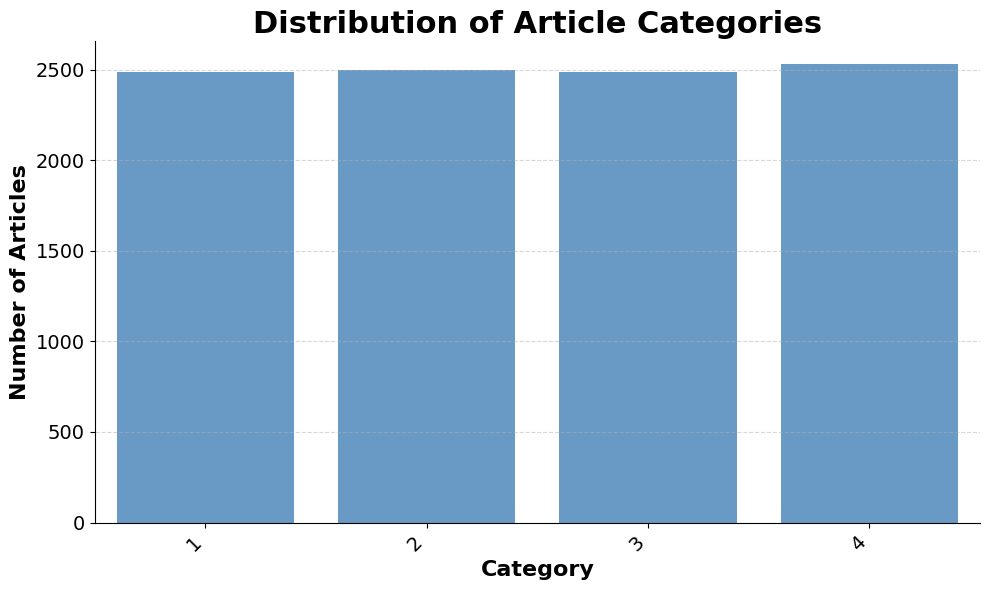

In [30]:
# Count the number of articles in each category and sort alphabetically
counts = df['category'].value_counts().sort_index()

# Visualize the distribution of categories using a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plot
sns.barplot(x=counts.index, y=counts.values, color='#5A9BD5', ax=ax)

# Set plot title, axis labels, and tick labels
ax.set_title('Distribution of Article Categories', fontsize=22, fontweight='bold')
ax.set_xlabel('Category', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Articles', fontsize=16, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=14)

# Remove spines from top and right sides of plot
sns.despine(top=True, right=True)

# Add horizontal grid lines to plot
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

**Observation**: The articles in each category are evenly distributed, hence they make up to a suitable model for text classification.

In [31]:
## Compute the length of each article in terms of the number of words
df['article_length'] = df['text'].apply(lambda x: len(x.split()))

## Print the descriptive statistics of article lengths
print(df['article_length'].describe())

count    10000.000000
mean        36.942700
std         10.254098
min         10.000000
25%         31.000000
50%         36.000000
75%         42.000000
max        139.000000
Name: article_length, dtype: float64


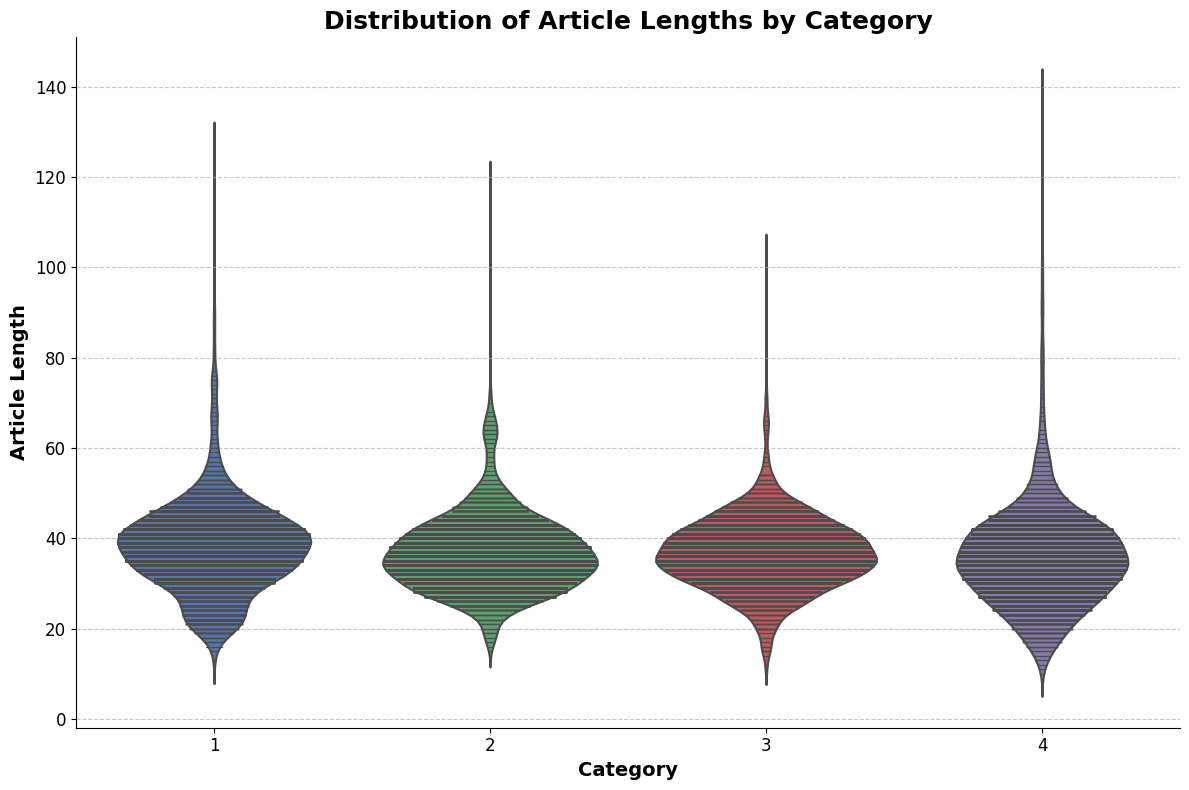

In [32]:
# Set a blue color palette
colors = ["#4c72b0", "#55a868", "#c44e52", "#8172b2"]

# Create a violin plot of article lengths by category
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(x="category", y="article_length", data=df, ax=ax, palette=colors, inner="stick", bw=0.2)
ax.set_title("Distribution of Article Lengths by Category", fontsize=18, fontweight="bold")
ax.set_xlabel("Category", fontsize=14, fontweight="bold")
ax.set_ylabel("Article Length", fontsize=14, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Remove spines from top and right sides of plot
sns.despine(top=True, right=True)

# Show the plot
plt.tight_layout()
plt.show()

**Observation**: Most of the articles have lengths ranging between 200 to 400 words.


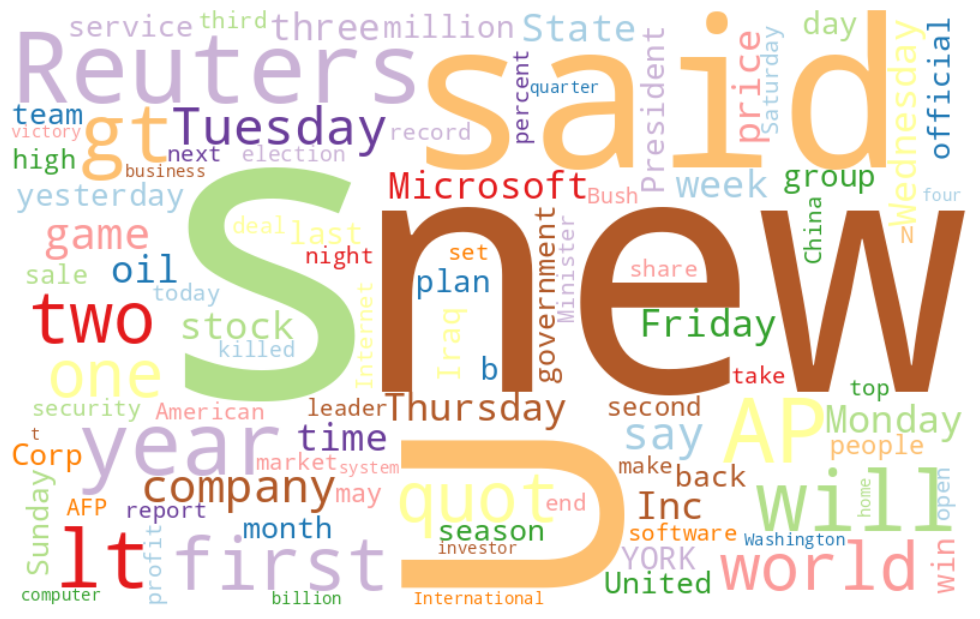

In [33]:
# Join all article titles into a single string
text = ' '.join(df['text'])

# Set wordcloud parameters
wordcloud = WordCloud(width=800, height=500, background_color='white',
                      colormap='Paired', collocations=False, max_words=100)
# Generate wordcloud
wordcloud.generate(text)

# Create plot and set plot parameters
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


# **Data Preprocessing**
The dataset being large, I have utilized a range of preprocessing techniques to optimize model performance. These include lowering the text case, removing punctuation, tokenizing, substituting words with synonyms, eliminating stop words, performing stemming and lemmatization, and handling negations. These techniques are aimed at improving model run time while retaining the integrity and quality of the data.

In [34]:
# Define function to get WordNet part of speech (POS) tag from Penn Treebank POS tag

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


# Define function to handle negations
def handle_negations(tokens):
    """Handle negations in a list of tokens"""
    negations = ["no", "not", "n't"]
    negated = False
    result = []
    for token in tokens:
        if negated:
            result.append("NOT_" + token)
        else:
            result.append(token)
        if token in negations:
            negated = not negated
    return result
    

# Define function to preprocess text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]','',text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if not token in stop_words]
    
    # Stemming 
    porter = PorterStemmer()
    tokens = [porter.stem(token) for token in tokens]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    
    # Negation handling
    tokens = handle_negations(tokens)
    
    # Join tokens back into text string
    text = ' '.join(tokens)
    
    return text

In [35]:
df['preprocessed_text'] = df['text'].apply(preprocess_text)

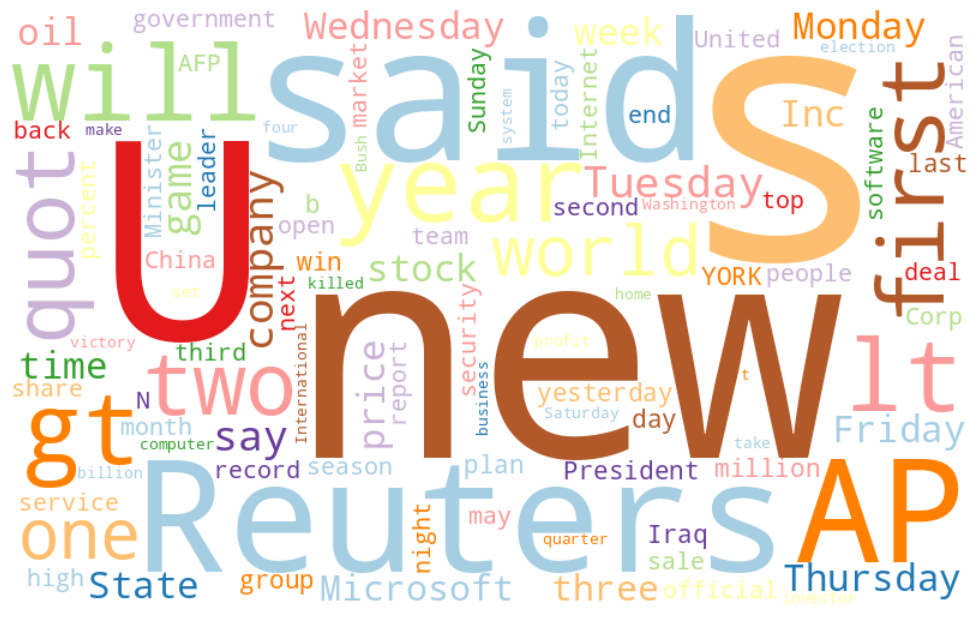

In [36]:
text = ' '.join(df['text'])

# Set wordcloud parameters
wordcloud = WordCloud(width=800, height=500, background_color='white',
                      colormap='Paired', collocations=False, max_words=100)
# Generate wordcloud
wordcloud.generate(text)

# Create plot and set plot parameters
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Observation:** 

The updated wordcloud after preprocessing looks much cleaner, with a majority of words making sense in relation to how most artciles are usually written.

**Encoding the category and text labels before feeding them to the model**

In [37]:
df['category'] = df['category'] - 1
test_df['category'] = test_df['category'] - 1

In [38]:
# Load the train & test data in text-label format
train_texts = df['text'].values
train_labels = df['category'].values

test_texts = test_df['text'].values
test_labels = test_df['category'].values

# **Training the DistilBERT model**

In [39]:
from transformers import DistilBertTokenizer

# Load pre-trained BERT tokenizer and encode text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# df['airline_sentiment'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

In [40]:
def get_data_loaders(train_inputs, train_labels, test_inputs, test_labels, batch_size):
    # Convert data to PyTorch tensors
    train_inputs = torch.tensor(train_inputs)
    train_labels = torch.tensor(train_labels)
    test_inputs = torch.tensor(test_inputs)
    test_labels = torch.tensor(test_labels)
    
    # Create TensorDataset objects
    train_data = TensorDataset(train_inputs, train_labels)
    test_data = TensorDataset(test_inputs, test_labels)
    
    # Create DataLoader objects
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, test_dataloader

In [41]:
from transformers import DistilBertForSequenceClassification

# Define data loaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load pre-trained BERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
# Move model to the device
model = model.to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr= 1e-5, eps=1e-8)
num_warmup_steps = int(len(train_dataloader) * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=5)
epochs = 5

# Define cross-entropy loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define early_stop
early_stop = 3
best_test_loss = float('inf')
best_epoch = 0
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    train_acc = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_acc += (outputs[1].detach().cpu().numpy().argmax(axis=1) == b_labels.cpu().numpy()).mean()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Evaluation
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            test_loss += loss.item()
            test_acc += (outputs[1].detach().cpu().numpy().argmax(axis=1) == b_labels.cpu().numpy()).mean()
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    
    print("Epoch {} - train loss: {:.3f} - train acc: {:.3f} - test loss: {:.3f} - test acc: {:.3f}".format(epoch, train_loss, train_acc, test_loss, test_acc))

    # Save the model
    if test_loss < best_test_loss:
        torch.save(model.state_dict(), 'distilbert_sentiment_model.pt')
        best_test_loss = test_loss
        best_epoch = epoch
        print("The model has been saved")

    # Stop training if the validation loss stops improving after certain epochs
    if epoch - best_epoch >= early_stop:
        print("Accuracy has not improved in {} epochs, stopping training".format(early_stop))
        break

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Epoch 0 - train loss: 0.830 - train acc: 0.773 - test loss: 0.757 - test acc: 0.819
The model has been saved
Epoch 1 - train loss: 0.778 - train acc: 0.806 - test loss: 0.757 - test acc: 0.819
Epoch 2 - train loss: 0.780 - train acc: 0.808 - test loss: 0.757 - test acc: 0.819
Epoch 3 - train loss: 0.778 - train acc: 0.806 - test loss: 0.757 - test acc: 0.819
Accuracy has not improved in 3 epochs, stopping training


**Observation:**

The model is performing with an 82% accuracy on the test set, when trained using only a part of the dataset. Each episode is taking about 10 minutes to execute, which is almost 1.5X faster when compared to the (base)bert model.

# **Evaluating the model's performance using Confusion matrix**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
model.load_state_dict(torch.load('distilbert_sentiment_model.pt'))
model = model.to(device)
model.eval()

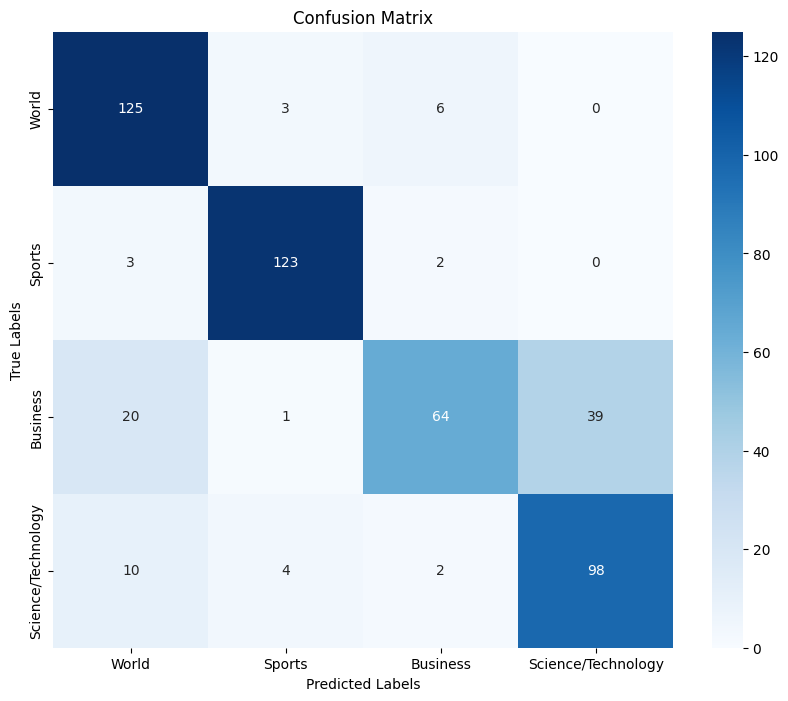

In [49]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs[0]
        predicted_labels.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (if available)
class_labels = ['World','Sports','Business','Science/Technology']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## **Result and Observation**
As the confusion matrix proves, the model is performing very well, classifying most of the content accurately. The DistilBERT model , similar to BERT, has some difficulty classifying 'Business' correctly, as it confuses them with science/technology. However, the performance was comparatively much better than the BERT model, while also being much faster. 